<a href="https://colab.research.google.com/github/Joshuas41/DecisionTree/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


IMPORT THƯ VIỆN




In [ ]:
!pip install stable-baselines3


import os
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import gym

TẠO HÀM

In [ ]:
#Create RL Env.
class SentimentAnalysisEnv(gym.Env):
    def __init__(self, data, vectorizer, model):
        super(SentimentAnalysisEnv, self).__init__()
        self.data = data
        self.vectorizer = vectorizer
        self.model = model
        self.current_step = 0
        self.max_steps = len(data)
        self.action_space = gym.spaces.Discrete(3)  # 3 hành động: negative, neutral, positive
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(X_train.shape[1],), dtype=float)
    def reset(self):
        self.current_step = 0
        return self.vectorizer.transform([self.data.iloc[self.current_step]['sents']]).toarray().flatten()

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = 1 if action == self.data.iloc[self.current_step - 1]['sentiments'] else 0
        observation = self.vectorizer.transform([self.data.iloc[self.current_step]['sents']]).toarray().flatten()
        return observation, reward, done, {}

In [ ]:
#Merge Data in train
data_folder_path = '/content/drive/MyDrive/_UIT-VSFC'

# Đọc và gộp dữ liệu từ thư mục 'train'
train_data = merge_data(os.path.join(data_folder_path, 'train', 'sents.txt'),
                        os.path.join(data_folder_path, 'train', 'sentiments.txt'),
                        os.path.join(data_folder_path, 'train', 'topics.txt'))
train_data.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-3-c327dfef5f03>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sents = pd.read_csv(sent_path, header=None, names=['sents'], delimiter='\t', error_bad_lines=False)
<ipython-input-3-c327dfef5f03>:3: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  sentiments = pd.read_csv(senti_path, header=None, names=['sentiments'], delimiter='\t', error_bad_lines=False)
<ipython-input-3-c327dfef5f03>:4: FutureWarning: The error_bad_lines argument has be

,sents,sentiments,topics
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0


In [ ]:
#Training data with TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(train_data['sents'])
y_train = train_data['sentiments']

dt_model = DecisionTreeClassifier(max_depth=20, min_samples_split=3, min_samples_leaf=10, random_state=42)
dt_model.fit(X_train, y_train)



DecisionTreeClassifier(max_depth=20, min_samples_leaf=10, min_samples_split=3,
                       random_state=42)

In [ ]:
!pip install 'shimmy>=0.2.1'
#RL Environment
env_dt = DummyVecEnv([lambda: SentimentAnalysisEnv(train_data, vectorizer, dt_model)])
#PPO Model
model_rl_dt = PPO("MlpPolicy", env_dt, verbose=1)


Using cpu device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [ ]:
#Training with RL
model_rl_dt.learn(total_timesteps=10000)


-----------------------------
| time/              |      |
|    fps             | 316  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 139         |
|    iterations           | 2           |
|    time_elapsed         | 29          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.019780654 |
|    clip_fraction        | 0.145       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.00133     |
|    learning_rate        | 0.0003      |
|    loss                 | 1.16        |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.0268     |
|    value_loss           | 9.06        |
-----------------------------------------
----------------------------------

Validation Accuracy (Decision Tree): 0.842082239720035

Classification Report (Validation Data - Decision Tree):
              precision    recall  f1-score  support
negative       0.908795  0.802493  0.852342     1043
neutral        1.000000  0.087379  0.160714      103
positive       0.795723  0.946491  0.864583     1140
accuracy       0.842082  0.842082  0.842082        0
macro avg      0.901506  0.612121  0.625880     2286
weighted avg   0.856517  0.842082  0.827284     2286


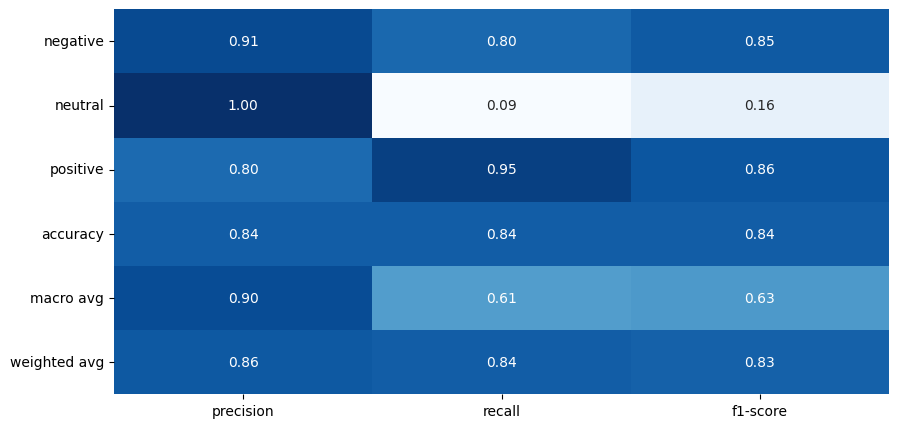


Test Accuracy (Decision Tree): 0.8300694883133292

Classification Report (Test Data - Decision Tree):
              precision    recall  f1-score  support
negative       0.888025  0.810504  0.847495     1409
neutral        0.333333  0.011976  0.023121      167
positive       0.791889  0.933333  0.856813     1590
accuracy       0.830069  0.830069  0.830069        0
macro avg      0.671082  0.585271  0.575810     3166
weighted avg   0.810486  0.830069  0.808691     3166


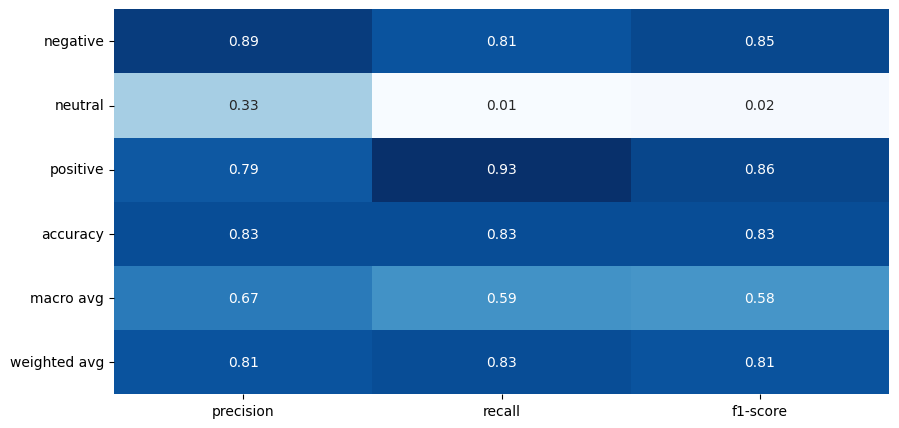

In [ ]:
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Dự đoán và đánh giá mô hình Decision Tree
val_predictions_dt = dt_model.predict(X_val)
test_predictions_dt = dt_model.predict(X_test)

# Đánh giá mô hình trên tập validation
val_accuracy_dt = accuracy_score(y_val, val_predictions_dt)
val_report_dt = classification_report(y_val, val_predictions_dt, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Đánh giá mô hình trên tập test
test_accuracy_dt = accuracy_score(y_test, test_predictions_dt)
test_report_dt = classification_report(y_test, test_predictions_dt, target_names=['negative', 'neutral', 'positive'], output_dict=True)

# Hiển thị kết quả bằng seaborn và pandas
def display_classification_report(report):
    df = pd.DataFrame(report).transpose()
    df['support'] = df['support'].astype(int)
    print(df)

    # Vẽ đồ thị
    plt.figure(figsize=(10, 5))
    sns.heatmap(df.drop(['support'], axis=1), annot=True, fmt=".2f", cmap="Blues", cbar=False)
    plt.show()

# In các giá trị
print(f'Validation Accuracy (Decision Tree): {val_accuracy_dt}')
print('\nClassification Report (Validation Data - Decision Tree):')
display_classification_report(val_report_dt)

print(f'\nTest Accuracy (Decision Tree): {test_accuracy_dt}')
print('\nClassification Report (Test Data - Decision Tree):')
display_classification_report(test_report_dt)


In [ ]:
# Dự đoán tâm trạng cho một đoạn văn bản mới
new_text = "Giảng viên vui  ."
new_text_vector = vectorizer.transform([new_text]).toarray().flatten()

# Dự đoán và in kết quả
action_dt, _ = model_rl_dt.predict([new_text_vector])

if action_dt[0] == 0:
    prediction_label_dt = "Negative"
elif action_dt[0] == 1:
    prediction_label_dt = "Neutral"
else:
    prediction_label_dt = "Positive"


# In kết quả
print("Predicted Label (RL - Decision Tree):", prediction_label_dt)


Predicted Label (RL - Decision Tree): Positive
